In [1]:
# Need to reverse the sequence because most recent apears first and oldest appears last

#!pip install tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from pandas import read_csv
from pandas import concat

from matplotlib import pyplot as plt

from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot


from numpy import sqrt 


from statsmodels.tsa.ar_model import AutoReg
from random import random

from pandas import DataFrame


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


from pmdarima.arima import auto_arima


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout


from sklearn.preprocessing import StandardScaler



C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
rmse_AR = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
mae_AR = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
mape_AR = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

rmse_ARIMAX = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
mae_ARIMAX = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
mape_ARIMAX = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

rmse_LSTM = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
mae_LSTM = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
mape_LSTM = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

rmse_RF = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
mae_RF = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
mape_RF = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

In [3]:
# Define global variables for training and testing

num_past_samples=12

num_train_samples=12000 + num_past_samples
# Train using 1000 hours

num_test_samples=96 + num_past_samples -1
# Predict 8 hours in future


In [4]:
# Updated datafile processing
# Run this cell and the cells below for different users to collect performance metrics

file = "309157.csv"
user_index=0

# file = "221634.csv"
# user_index=1

#file = "1352464.csv"
#user_index=2

#file = "2033176.csv"
#user_index=3

#file = "72492570.csv"
#user_index=4

df = pd.read_csv(file, low_memory=False)
df = df[['timestamp', 'bg', 'insulin', 'carbs']]

print(df.shape)
df.head()
df = df.loc[df.bg!=" null", :]
print(df.shape)

# Remove all columns except BG to keep only endogenous variable BG: 
df_endogenous = df.drop(['timestamp', 'insulin', 'carbs'], axis=1)

print('Endogenous Data (BG)...')
print(df_endogenous.head)


df_exogenous = df.drop(['timestamp', 'bg'], axis=1)
print('Exogenous Data (insulin and carbs)...')
print(df_exogenous.head)


(59399, 4)
(59061, 4)
Endogenous Data (BG)...
<bound method NDFrame.head of          bg
0        69
1       199
2       204
3       208
4       215
...     ...
59394   126
59395   127
59396   128
59397   128
59398    85

[59061 rows x 1 columns]>
Exogenous Data (insulin and carbs)...
<bound method NDFrame.head of        insulin  carbs
0          0.0    0.0
1          0.0    0.0
2          0.0    0.0
3          0.0    0.0
4          0.0    0.0
...        ...    ...
59394      0.0    0.0
59395      0.0    0.0
59396      0.0    0.0
59397      0.0    1.0
59398      0.0    0.0

[59061 rows x 2 columns]>


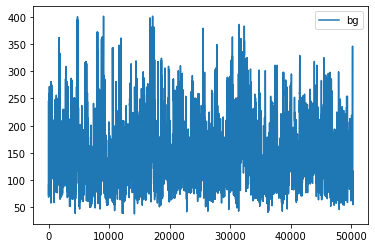

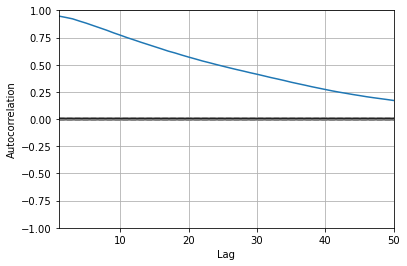

In [5]:

# Select first N entries for training and testing
N = 50000
# N = 59000

df_endogenous_numeric = df_endogenous.apply(pd.to_numeric, errors='coerce')
df_endogenous_numeric_selected=df_endogenous_numeric.head(N)
df_endogenous_numeric_selected.plot()
plt.show()

df_exogenous_numeric = df_exogenous.apply(pd.to_numeric, errors='coerce')
df_exogenous_numeric_selected=df_exogenous_numeric.head(N)


autocorrelation_plot(df_endogenous_numeric_selected)
#pyplot.xlim(1,50)
#pyplot.show()

plt.xlim(1,50)
plt.show()


# Try selected BG samples of a user
# data_endogenous = numpy.array(df_endogenous_numeric_selected)
# data_exogenous = numpy.array(df_exogenous_numeric_selected)

data_endogenous = np.array(df_endogenous_numeric_selected)
data_exogenous = np.array(df_exogenous_numeric_selected)

df_for_training=df_endogenous.iloc[0:num_train_samples,:]
df_for_testing=df_endogenous.iloc[num_train_samples:num_train_samples+num_test_samples+1,:]

# num_test_samples=8000
train_endogenous, test_endogenous = data_endogenous[0:num_train_samples], data_endogenous[num_train_samples:num_train_samples+num_test_samples+1]
train_exogenous, test_exogenous = data_exogenous[0:num_train_samples], data_exogenous[num_train_samples:num_train_samples+num_test_samples+1]


In [6]:
print('train_endogenous shape == {}.'.format(train_endogenous.shape))
print('test_endogenous shape == {}.'.format(test_endogenous.shape))

train_endogenous shape == (12012, 1).
test_endogenous shape == (108, 1).


In [7]:
# from pmdarima.arima import auto_arima

#model_ARIMAX = auto_arima(train_endogenous, exogenous=train_exogenous, trace=True, error_action="ignore", suppress_warnings=True)
model_ARIMAX = auto_arima(train_endogenous, xreg=train_exogenous, trace=True, error_action="ignore", suppress_warnings=True)

model_ARIMAX.fit(train_endogenous, xreg=train_exogenous)

forecast_ARIMAX = model_ARIMAX.predict(n_periods=num_test_samples+1, xreg=test_exogenous)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=105343.266, Time=8.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=132852.606, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=107494.407, Time=0.47 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=122719.224, Time=1.58 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=156463.305, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=105389.935, Time=4.38 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=105408.995, Time=4.41 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=105293.778, Time=4.14 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=105302.240, Time=8.45 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=105296.298, Time=13.50 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=105295.807, Time=3.78 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=105299.328, Time=10.14 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=105292.338, Time=15.54 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=105301.009, Time=2.74 sec
 A

In [8]:
print("shape of forecast_ARIMAX:", forecast_ARIMAX.shape)

shape of forecast_ARIMAX: (108,)


In [58]:
forecast_ARIMAX_uniform = forecast_ARIMAX[num_past_samples:]
print("shape of forecast_ARIMAX_uniform:", forecast_ARIMAX_uniform.shape)

shape of forecast_ARIMAX_uniform: (96,)


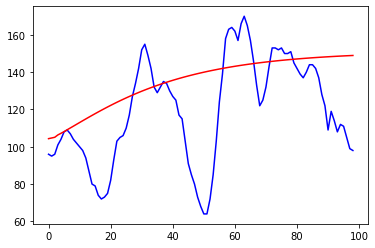

Results for the ARIMAX Model...
rmse_test_dataset_ARIMAX: 35.69395972848119
mae_test_dataset_ARIMAX: 26.18053676659292
mape_test_dataset_ARIMAX: 0.30485460369438544


In [9]:
#plot the predictions for the test set
plt.plot(test_endogenous[0:99], label='Test (Desired Output)', color='blue')
plt.plot(forecast_ARIMAX[0:99], label='Prediction (Forecast)', color='red')
plt.show()

print('Results for the ARIMAX Model...')

rmse_test_dataset_ARIMAX = sqrt(mean_squared_error(test_endogenous, forecast_ARIMAX))
print('rmse_test_dataset_ARIMAX:', rmse_test_dataset_ARIMAX)

mae_test_dataset_ARIMAX= mean_absolute_error(test_endogenous, forecast_ARIMAX)
print('mae_test_dataset_ARIMAX:', mae_test_dataset_ARIMAX)

mape_test_dataset_ARIMAX= mean_absolute_percentage_error(test_endogenous, forecast_ARIMAX)
print('mape_test_dataset_ARIMAX:', mape_test_dataset_ARIMAX)

rmse_ARIMAX[user_index]=rmse_test_dataset_ARIMAX
mae_ARIMAX[user_index]=mae_test_dataset_ARIMAX
mape_ARIMAX[user_index]=mape_test_dataset_ARIMAX



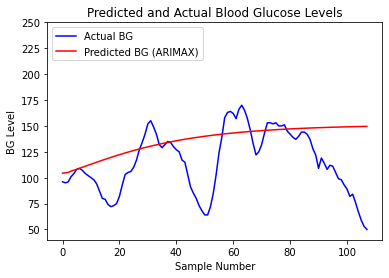

In [10]:
# Plot ARIMAX results
plt.plot(test_endogenous, color='blue', label="Actual BG")
plt.plot(forecast_ARIMAX, color='red', label="Predicted BG (ARIMAX)")
plt.title('Predicted and Actual Blood Glucose Levels')
plt.xlabel('Sample Number')
plt.ylabel('BG Level')
plt.ylim(40, 250)
plt.legend(loc="upper left")
plt.show()

In [11]:
# AutoRegressive Model for this new data set

# fit model
# 12
target_lags=12
model_AR = AutoReg(train_endogenous, lags=target_lags)
model_AR_fit = model_AR.fit()
# let's make prediction
# forecast_AR = model_AR_fit.predict(len(train_endogenous), len(train_endogenous)+num_test_samples-1)
forecast_AR = model_AR_fit.predict(len(train_endogenous), len(train_endogenous)+num_test_samples)
#print(forecast)

print("shape of forecast_AR:", forecast_AR.shape)


print('Results for the AR Model...')

rmse_test_dataset_AR = sqrt(mean_squared_error(test_endogenous, forecast_AR))
print('rmse_test_dataset_AR:', rmse_test_dataset_AR)

mae_test_dataset_AR= mean_absolute_error(test_endogenous, forecast_AR)
print('mae_test_dataset_AR:', mae_test_dataset_AR)

mape_test_dataset_AR= mean_absolute_percentage_error(test_endogenous, forecast_AR)
print('mape_test_dataset_AR:', mape_test_dataset_AR)

rmse_AR[user_index]=rmse_test_dataset_AR
mae_AR[user_index]=mae_test_dataset_AR
mape_AR[user_index]=mape_test_dataset_AR


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


shape of forecast_AR: (108,)
Results for the AR Model...
rmse_test_dataset_AR: 34.40932684073273
mae_test_dataset_AR: 25.29132546727023
mape_test_dataset_AR: 0.29312887741842214


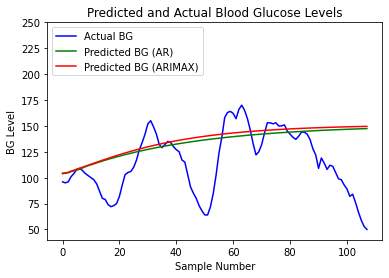

In [12]:
# Plot AR and ARIMAX results
plt.plot(test_endogenous, color='blue', label="Actual BG")
plt.plot(forecast_AR, color='green', label="Predicted BG (AR)")
plt.plot(forecast_ARIMAX, color='red', label="Predicted BG (ARIMAX)")
plt.title('Predicted and Actual Blood Glucose Levels')
plt.xlabel('Sample Number')
plt.ylabel('BG Level')
plt.ylim(40, 250)
plt.legend(loc="upper left")
plt.show()

In [59]:
forecast_AR_uniform = forecast_AR[num_past_samples:]
print("shape of forecast_ARI_uniform:", forecast_AR_uniform.shape)

shape of forecast_ARI_uniform: (96,)


In [13]:

df_for_training=df_endogenous.iloc[0:num_train_samples,:]
df_for_testing=df_endogenous.iloc[num_train_samples:num_train_samples+num_test_samples+1,:]


In [14]:
print(df_for_training.head())
print(df_for_training.tail())
print('Training Dataset Shape: ', df_for_training.shape)

     bg
0    69
1   199
2   204
3   208
4   215
         bg
12082   117
12083   114
12084   108
12085   105
12086   100
Training Dataset Shape:  (12012, 1)


In [15]:
print(df_for_testing.head())
print(df_for_testing.tail())
print('Testing Dataset Shape: ', df_for_testing.shape)

         bg
12087    96
12088    95
12089    96
12090   101
12091   104
        bg
12190   76
12191   67
12192   59
12193   53
12194   50
Testing Dataset Shape:  (108, 1)


In [16]:
# store original BG for a future comparison with predicted BG

original_bg = df_for_testing[['bg']]
print(original_bg.head)


<bound method NDFrame.head of          bg
12087    96
12088    95
12089    96
12090   101
12091   104
...     ...
12190    76
12191    67
12192    59
12193    53
12194    50

[108 rows x 1 columns]>


In [17]:
# Prepare the training dataset

#LSTM uses sigmoid and tanh that are sensitive to magnitude so dataset values need to be normalized
# normalize the dataset
scaler_training = StandardScaler()
scaler_training = scaler_training.fit(df_for_training)
df_for_training_scaled = scaler_training.transform(df_for_training)


# Per LSTM requirements, reshape the input data into n_samples x timesteps x n_features. 
# In our BG example, the n_features is 3. 
# Try different numbers of past samples as "timesteps" (=n_past) for training
# For data samples every 5 minutes, timesteps= 12 corresponds to last 1 hour data


#Empty lists to be populated using formatted training data
# trainX: Training input data (=past BG, insulin, and carbs)
# trainY: Training target output (=current BG)
trainX = []
trainY = []

n_future = 1   # Number of samples we want to predict into the future at a given instant
n_past = num_past_samples # Number of past samples used to predict the future.

# Reformat input data into a shape: (n_samples x timesteps x n_features)
# In this example, df_for_training_scaled has a shape (59047, 3) for test_no_null.csv
# 59047: the number of data points 
# 3: the number of columns (= endogenous variables that influence BG).

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

# Example Values for n_past=14:
# trainX shape == (59047, 14, 3).
# trainY shape == (59047, 1).
# In this example case, trainX has a shape (59047, 14, 3). 
# 59047 because we are looking back 14 instants (59061 - 14 = 59047). 
# We cannot look back 14 instants until we get to the 15th instant. 
# trainY has a shape (59047, 1). Our model only predicts BG (a single variable) 
# The model needs 3 variables (3 in my example) to make this prediction. 


trainX shape == (12000, 12, 1).
trainY shape == (12000, 1).


In [18]:
# Prepare the testing dataset

#LSTM uses sigmoid and tanh that are sensitive to magnitude so dataset values need to be normalized
# normalize the dataset
scaler_testing = StandardScaler()
scaler_testing = scaler_testing.fit(df_for_testing)
df_for_testing_scaled = scaler_testing.transform(df_for_testing)


#Empty lists to be populated using formatted test data
# testX: Training input data (=past BG, insulin, and carbs)
# testY: Training target output (=current BG)
testX = []
testY = []

n_future = 1   # Number of samples we want to predict into the future at a given instant
n_past = num_past_samples  # Number of past samples used to predict the future.

# Reformat input data into a shape: (n_samples x timesteps x n_features)

for i in range(n_past, len(df_for_testing_scaled) - n_future +1):
    testX.append(df_for_testing_scaled[i - n_past:i, 0:df_for_testing.shape[1]])
    testY.append(df_for_testing_scaled[i + n_future - 1:i + n_future, 0])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))


testX shape == (96, 12, 1).
testY shape == (96, 1).


In [19]:
# define the LSTM model
# find out the difference between LSTM and autoencoder
layer1_units=128
layer2_units=32
#layer1_units=64
#layer2_units=32
model = Sequential()
model.add(LSTM(layer1_units, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(layer2_units, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 87,201
Trainable params: 87,201
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
675/675 [==============================] - 7s 8ms/step - loss: 0.1722 - val_loss: 0.1602
Epoch 2/20
675/675 [==============================] - 6s 8ms/step - loss: 0.1248 - val_loss: 0.1513
Epoch 3/20
675/675 [==============================] - 5s 7ms/step - loss: 0.1212 - val_loss: 0.1441
Epoch 4/20
675/675 [==============================] - 5s 7ms/step - loss: 0.1138 - val_loss: 0.1405
Epoch 5/20
675/675 [==============================] - 5s 7ms/step - loss: 0.1152 - val_loss: 0.1462
Epoch 6/20
675/675 [==============================] - 5s 7ms/step - loss: 0.1116 - val_loss: 0.1441
Epoch 7/20
675/675 [==============================] - 5s 7ms/step - loss: 0.1069 - val_loss: 0.1303
Epoch 8/20
675/675 [==============================] - 5s 7ms/step - loss: 0.1072 - val_loss: 0.1375
Epoch 9/20
675/675 [==============================] - 5s 8ms/step - loss: 0.1059 - val_loss: 0.1272
Epoch 10/20
675/675 [==============================] - 7s 10ms/step - loss: 0.1059 - val_loss: 0.137

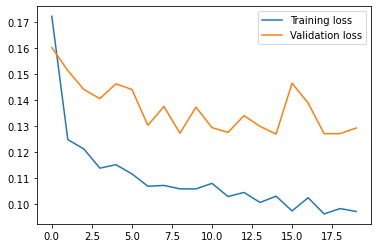

In [20]:
# fit the model
num_epochs_lstm=20
history = model.fit(trainX, trainY, epochs=num_epochs_lstm, batch_size=16, validation_split=0.1, verbose=1)
# history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)


plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

#Predicting for the test dataset...

# n_past = 16
# n_instants_for_prediction=15  #let us predict 15 samples

#Make prediction
prediction_test = model.predict(testX) 

#Perform inverse transformation to rescale back to original range
#Since we used 3 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 3 times and discard them after inverse transform
prediction_test_copies = np.repeat(prediction_test, df_for_testing.shape[1], axis=-1)
y_pred_test = scaler_testing.inverse_transform(prediction_test_copies)[:,0]

yhat_lstm=y_pred_test

# y_actual= trainY[-n_days_for_prediction:]

In [21]:
y_actual_original= original_bg[num_past_samples:]
length_y_actual_original=len(y_actual_original)
length_y_actual_original
#y_actual_vector[0:n_days_for_prediction]=y_actual
#y_actual_vector
y_actual= y_actual_original.to_numpy()


In [22]:
y_actual=y_actual.astype(np.int64)

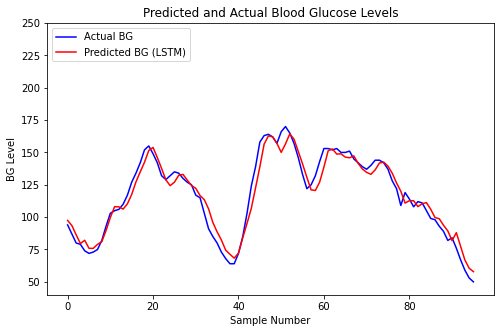

Results for the LSTM Model...
layer1_units: 128
layer2_units: 32
num_epochs_lstm: 20
rmse_test_dataset_lstm: 7.161139736783355
mae_test_dataset_lstm: 5.682555238405864
mape_test_dataset_lstm: 0.053642384204728145


In [23]:
# Quantify the performance of the LSTM model


#plot the predictions for the test set

plt.rcParams["figure.figsize"] = (8,5)
plt.plot(y_actual, label='Actual BG', color='blue')
plt.plot(yhat_lstm, label='Predicted BG (LSTM)', color='red')
plt.title('Predicted and Actual Blood Glucose Levels')
plt.xlabel('Sample Number')
plt.ylabel('BG Level')
plt.ylim(40, 250)
plt.legend(loc="upper left")
plt.show()

print('Results for the LSTM Model...')
print('layer1_units:', layer1_units)
print('layer2_units:', layer2_units)
print('num_epochs_lstm:', num_epochs_lstm)


rmse_test_dataset_lstm = sqrt(mean_squared_error(y_actual, yhat_lstm))
print('rmse_test_dataset_lstm:', rmse_test_dataset_lstm)

mae_test_dataset_lstm= mean_absolute_error(y_actual, yhat_lstm)
print('mae_test_dataset_lstm:', mae_test_dataset_lstm)

mape_test_dataset_lstm= mean_absolute_percentage_error(y_actual, yhat_lstm)
print('mape_test_dataset_lstm:', mape_test_dataset_lstm)

rmse_LSTM[user_index]=rmse_test_dataset_lstm
mae_LSTM[user_index]=mae_test_dataset_lstm
mape_LSTM[user_index]=mape_test_dataset_lstm




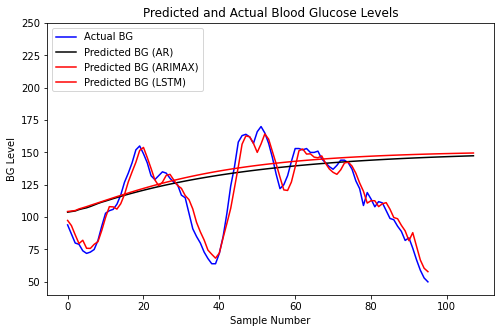

In [24]:
# Plot AR, ARIMAX, and LSTM results
plt.plot(y_actual, color='blue', label="Actual BG")
plt.plot(forecast_AR, color='black', label="Predicted BG (AR)")
plt.plot(forecast_ARIMAX, color='red', label="Predicted BG (ARIMAX)")
plt.plot(yhat_lstm, color='red', label="Predicted BG (LSTM)")
# plt.plot(y_pred_test, label='Prediction (Forecast)', color='black')
plt.title('Predicted and Actual Blood Glucose Levels')
plt.xlabel('Sample Number')
plt.ylabel('BG Level')
plt.ylim(40, 250)
plt.legend(loc="upper left")
plt.show()

In [25]:
print('df_for_training Shape: ', df_for_training.shape)
print('df_for_training_scaled Shape: ', df_for_training_scaled.shape)
print('df_for_testing Shape: ', df_for_testing.shape)
print('df_for_testing_scaled Shape: ', df_for_testing_scaled.shape)

print('n_future: ', n_future)
print('n_past: ', n_past)

print('len(df_for_training_scaled): ', len(df_for_training_scaled))
print('len(df_for_training): ', len(df_for_training))


df_for_training Shape:  (12012, 1)
df_for_training_scaled Shape:  (12012, 1)
df_for_testing Shape:  (108, 1)
df_for_testing_scaled Shape:  (108, 1)
n_future:  1
n_past:  12
len(df_for_training_scaled):  12012
len(df_for_training):  12012


In [26]:
print(type(df_for_training))
print(type(df_for_training_scaled))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [27]:
#Empty lists to be populated using formatted training data
# trainX_rf: Training input data (=past BG, insulin, and carbs)
# trainY_rf: Training target output (=current BG)
# No scaling for these random forest training and test datasets

array_for_training=df_for_training.to_numpy()

trainX_rf = []
trainY_rf = []
for i in range(n_past, len(df_for_training) - n_future +1):
    trainX_rf.append(array_for_training[i - n_past:i, 0:df_for_training.shape[1]])
    trainY_rf.append(array_for_training[i + n_future - 1:i + n_future, 0])

#print('trainX_rf Shape: ', trainX_rf.shape)
#print('trainY_rf Shape: ', trainY_rf.shape)
trainX_rf, trainY_rf = np.array(trainX_rf), np.array(trainY_rf)

print('trainX_rf Shape: ', trainX_rf.shape)
print('trainY_rf Shape: ', trainY_rf.shape)

trainX_rf Shape:  (12000, 12, 1)
trainY_rf Shape:  (12000, 1)


In [28]:
trainX_rf[0,:]

array([[' 69'],
       [' 199'],
       [' 204'],
       [' 208'],
       [' 215'],
       [' 219'],
       [' 223'],
       [' 229'],
       [' 237'],
       [' 90'],
       [' 246'],
       [' 80']], dtype=object)

In [29]:
trainY_rf[0,:]

array([' 80'], dtype=object)

In [30]:
array_for_testing=df_for_testing.to_numpy()

testX_rf = []
testY_rf = []
for i in range(n_past, len(df_for_testing) - n_future +1):
    testX_rf.append(array_for_testing[i - n_past:i, 0:df_for_testing.shape[1]])
    testY_rf.append(array_for_testing[i + n_future - 1:i + n_future, 0])

testX_rf, testY_rf = np.array(testX_rf), np.array(testY_rf)

print('testX_rf Shape: ', testX_rf.shape)
print('testY_rf Shape: ', testY_rf.shape)

testX_rf Shape:  (96, 12, 1)
testY_rf Shape:  (96, 1)


In [31]:
testX_rf[0,:]

array([[' 96'],
       [' 95'],
       [' 96'],
       [' 101'],
       [' 104'],
       [' 108'],
       [' 109'],
       [' 107'],
       [' 104'],
       [' 102'],
       [' 100'],
       [' 98']], dtype=object)

In [32]:
trainY_rf[0,:]

array([' 80'], dtype=object)

In [33]:
print('trainX_rf shape[0] == {}.'.format(trainX_rf.shape[0]))
print('trainX_rf shape[1] == {}.'.format(trainX_rf.shape[1]))
print('trainX_rf shape[2] == {}.'.format(trainX_rf.shape[2]))

trainX_rf_2D=np.reshape(trainX_rf,(trainX_rf.shape[0], trainX_rf.shape[1]*trainX_rf.shape[2]))
print('trainX_rf_2D shape == {}.'.format(trainX_rf_2D.shape))
print('trainY_rf shape == {}.'.format(trainY_rf.shape))

testX_rf_2D=np.reshape(testX_rf,(testX_rf.shape[0], testX_rf.shape[1]*testX_rf.shape[2]))
print('testX_rf_2D shape == {}.'.format(testX_rf_2D.shape))

print('testY_rf shape == {}.'.format(testY_rf.shape))

trainX_rf shape[0] == 12000.
trainX_rf shape[1] == 12.
trainX_rf shape[2] == 1.
trainX_rf_2D shape == (12000, 12).
trainY_rf shape == (12000, 1).
testX_rf_2D shape == (96, 12).
testY_rf shape == (96, 1).


In [34]:
testX_rf_2D[0,:]

array([' 96', ' 95', ' 96', ' 101', ' 104', ' 108', ' 109', ' 107',
       ' 104', ' 102', ' 100', ' 98'], dtype=object)

In [36]:
testY_rf[0,:]

array([' 94'], dtype=object)

In [35]:
# define the random forest regressor
from sklearn.ensemble import RandomForestRegressor

trainX_rf_2D, trainY_rf = np.array(trainX_rf_2D), np.array(trainY_rf)

# define the random forest regressor model and fit model to training dataset
# rf_model = RandomForestRegressor(n_estimators=10) 
# Works for num_rf_estimators=10 but accuracy could be improved
num_rf_estimators=50
rf_model = RandomForestRegressor(n_estimators=num_rf_estimators)
rf_model.fit(trainX_rf_2D, trainY_rf.ravel())

# make a one-step prediction
yhat_rf = rf_model.predict(testX_rf_2D)
# print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

print('yhat_rf shape == {}.'.format(yhat_rf.shape))


yhat_rf shape == (96,).


In [38]:
yhat_rf

array([ 96.64      ,  92.5       ,  88.46      ,  74.38      ,
        81.34      ,  77.52      ,  75.68      ,  79.        ,
        78.26      ,  90.66      , 100.9       , 110.42      ,
       111.22      , 106.7       , 112.04      , 121.44      ,
       129.52      , 138.68      , 147.26      , 161.43666667,
       160.34      , 137.72      , 137.94      , 128.46      ,
       129.44      , 130.16      , 134.36      , 133.705     ,
       126.76      , 126.74      , 124.68      , 114.14      ,
       111.78      ,  98.28      ,  86.46      , 105.62      ,
        77.78      ,  99.48      ,  67.96      ,  76.04      ,
        70.86      ,  82.18      ,  97.96      , 115.86      ,
       132.88      , 147.5       , 164.46      , 172.4       ,
       165.64      , 159.7       , 157.56      , 162.46      ,
       159.28      , 152.12      , 156.54      , 146.16      ,
       134.54      , 135.40333333, 133.76      , 131.        ,
       147.2       , 159.72      , 154.34      , 155.92

In [36]:
print('Results for the Random Forest Model...')
print('Number of estimators:', num_rf_estimators)

rmse_test_dataset_rf = sqrt(mean_squared_error(y_actual, yhat_rf))
print('rmse_test_dataset_rf:', rmse_test_dataset_rf)

mae_test_dataset_rf= mean_absolute_error(y_actual, yhat_rf)
print('mae_test_dataset_rf:', mae_test_dataset_rf)

mape_test_dataset_rf= mean_absolute_percentage_error(y_actual, yhat_rf)
print('mape_test_dataset_rf:', mape_test_dataset_rf)

rmse_RF[user_index]=rmse_test_dataset_rf
mae_RF[user_index]=mae_test_dataset_rf
mape_RF[user_index]=mape_test_dataset_rf


Results for the Random Forest Model...
Number of estimators: 50
rmse_test_dataset_rf: 6.990538763230734
mae_test_dataset_rf: 5.334788194444445
mape_test_dataset_rf: 0.05321774974044249


In [60]:
#df = pd.DataFrame({"Actual BG" : y_actual.vallues, "Predicted BG (LSTM)" : yhat_lstm.values})
#df.to_csv("ModelResults.csv", index=False)

#, "Predicted BG (Random Forest" : yhat_rf, "Predicted BG (AR)" : forecast_AR, "Predicted BG (ARIMAX)" : forecast_ARIMAX })
C = "Actual BG"
pd.DataFrame(y_actual).to_csv("Actual BG.csv", index=False, header=C)
pd.DataFrame(yhat_lstm).to_csv("Predicted LSTM.csv", index=False, header=C)
pd.DataFrame(yhat_rf).to_csv("Predicted Random Forest.csv", index=False, header=C)
pd.DataFrame(forecast_AR_uniform).to_csv("Predicted AR.csv", index=False, header=C)
pd.DataFrame(forecast_ARIMAX_uniform).to_csv("Predicted ARIMAX.csv", index=False, header=C)

#Colors: Actual BG: Blue, LSTM: Red, Random Forest: Green, AR: Black, ARIMAX: Orange

In [ ]:
# Plot AR, ARIMAX, and LSTM results
# plt.rcParams["figure.figsize"] = (8,5.5)
plt.rcParams["figure.figsize"] = (8, 5)
plt.plot(y_actual, color='blue', label="Actual BG")
plt.plot(forecast_AR, color='black', label="Predicted BG (AR)")
plt.plot(forecast_ARIMAX, color='orange', label="Predicted BG (ARIMAX)")
plt.plot(yhat_lstm, color='red', label="Predicted BG (LSTM)")
plt.plot(yhat_rf, color='green', label="Predicted BG (Random Forest)")
# plt.plot(y_pred_test, label='Prediction (Forecast)', color='black')
plt.title('Predicted and Actual Blood Glucose Levels')
plt.xlabel('Sample Number')
plt.ylabel('BG Level')
plt.ylim(40, 250)
plt.legend(loc="upper left")
plt.show()

In [41]:
# Stored Results for display


rmse_ARIMAX_stored=[35.149, 85.342, 50.888, 47.731 ]
mae_ARIMAX_stored=[25.757, 80.250, 41.529, 39.610 ]
mape_ARIMAX_stored=[0.299, 0.505, 0.301, 0.3727 ]

rmse_AR_stored=[34.409, 41.175, 45.267, 47.997 ]
mae_AR_stored=[25.291, 35.642, 37.687, 39.996 ]
mape_AR_stored=[0.293, 0.227, 0.310, 0.376 ]

rmse_LSTM_stored=[7.989, 6.008, 6.715, 16.636 ]
mae_LSTM_stored=[6.579, 4.172, 4.856, 10.084 ]
mape_LSTM_stored=[0.0597, 0.0271, 0.0422, 0.0973]

rmse_RF_stored=[7.263, 5.631, 6.521, 16.660]
mae_RF_stored=[5.797, 3.714, 4.486, 10.511]
mape_RF_stored=[0.0558, 0.0245, 0.0373, 0.101]


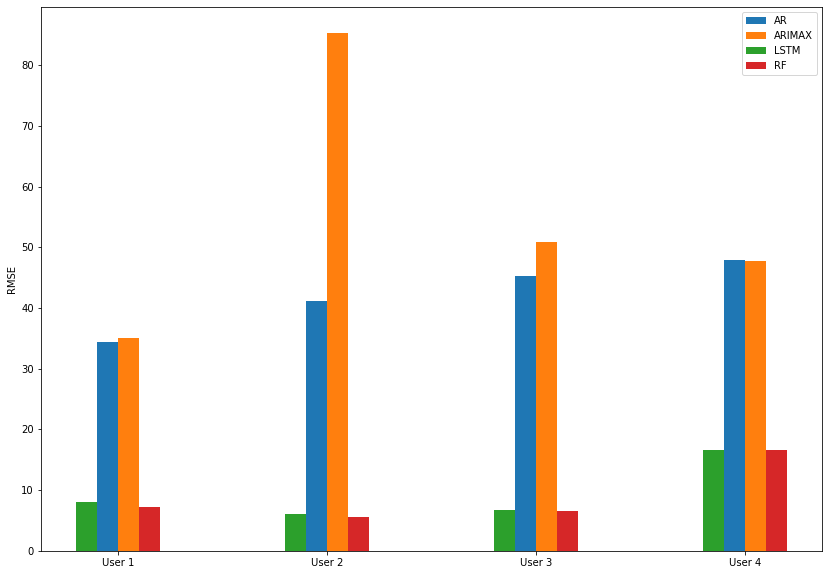

In [42]:
# Visualization of the Performance Metric"RMSI"
users = ['User 1','User 2','User 3','User 4']
# users = ['User 1','User 2','User 3','User 4','User 5']

x_axis = np.arange(len(users))

# Multi bar Chart

plt.bar(x_axis -0.05, rmse_AR_stored, width=0.1, label = 'AR')
plt.bar(x_axis +0.05, rmse_ARIMAX_stored, width=0.1, label = 'ARIMAX')
plt.bar(x_axis -0.15, rmse_LSTM_stored, width=0.1, label = 'LSTM')
plt.bar(x_axis +0.15, rmse_RF_stored, width=0.1, label = 'RF')
plt.ylabel('RMSE')

# Xticks

plt.xticks(x_axis, users)

# Add legend

plt.legend()

# Display

plt.show()

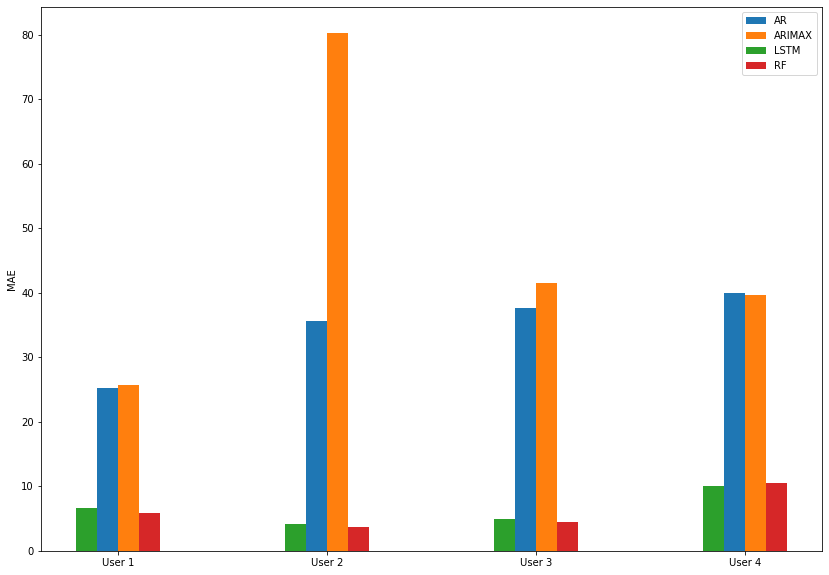

In [49]:
# Visualization of the Performance Metric"MAE"
users = ['User 1','User 2','User 3','User 4']
# users = ['User 1','User 2','User 3','User 4','User 5']

x_axis = np.arange(len(users))

# Multi bar Chart

plt.bar(x_axis -0.05, mae_AR_stored, width=0.1, label = 'AR')
plt.bar(x_axis +0.05, mae_ARIMAX_stored, width=0.1, label = 'ARIMAX')
plt.bar(x_axis -0.15, mae_LSTM_stored, width=0.1, label = 'LSTM')
plt.bar(x_axis +0.15, mae_RF_stored, width=0.1, label = 'RF')
plt.ylabel('MAE')

# Xticks

plt.xticks(x_axis, users)

# Add legend

plt.legend()

# Display

plt.show()

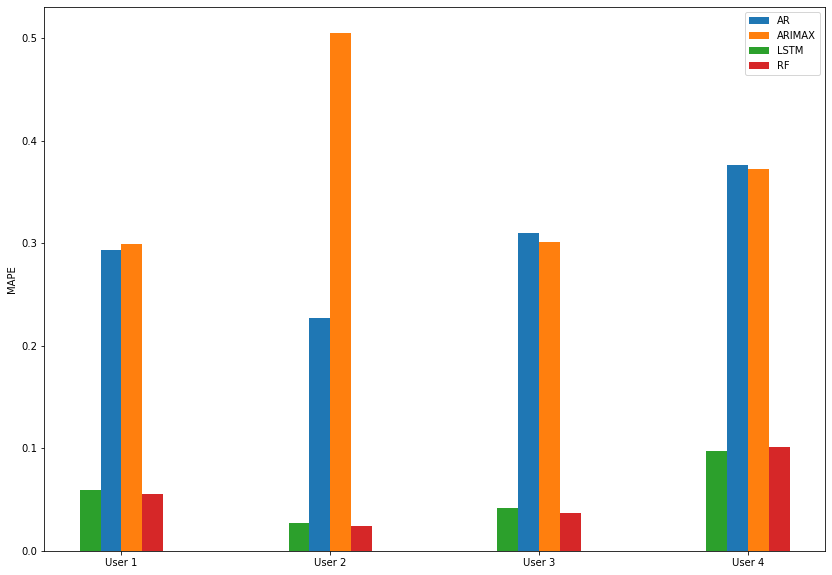

In [51]:
# Visualization of the Performance Metric"MAPE"
users = ['User 1','User 2','User 3','User 4']
# users = ['User 1','User 2','User 3','User 4','User 5']

x_axis = np.arange(len(users))

# Multi bar Chart

plt.bar(x_axis -0.05, mape_AR_stored, width=0.1, label = 'AR')
plt.bar(x_axis +0.05, mape_ARIMAX_stored, width=0.1, label = 'ARIMAX')
plt.bar(x_axis -0.15, mape_LSTM_stored, width=0.1, label = 'LSTM')
plt.bar(x_axis +0.15, mape_RF_stored, width=0.1, label = 'RF')
plt.ylabel('MAPE')

# Xticks

plt.xticks(x_axis, users)

# Add legend

plt.legend()

# Display

plt.show()